<a href="https://colab.research.google.com/github/geoskimoto/AWDB_SOAP_Request/blob/main/SiteCharacterization02_22_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To Do's

*   Convert years to water year
*   Add option to color code each year/make each year a different series
*   Add function comparing descriptive statistics in n yr blocks.  
*   If time, eigendecompose/create cov matrix for each year and compare descrip stats of eigenvectors 



### Library imports

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
import statsmodels.api as sm
from functools import reduce

In [192]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [193]:
cd /content/gdrive/My Drive/Projects/Work/SiteComparisons/Data

/content/gdrive/My Drive/Projects/Work/SiteComparisons/Data


In [194]:
ls

Data_parsing.ipynb     OR_WY1990-2020.xlsx    WA_WY1990-2020.xlsx
OR_1991-2021_raw.xlsx  WA_1991-2001_raw.xlsx
OR_1991-2021.xlsx      WA_1991-2021.xlsx


### Data Import and Prep

In [195]:
WA_Sites = pd.read_excel('WA_WY1990-2020.xlsx')
# pd.to_datetime(WA_Sites['Date'])
WA_Sites.set_index('Date',inplace=True)
# WA_Sites.sample(5)

OR_Sites = pd.read_excel('OR_WY1990-2020.xlsx')
# pd.to_datetime(OR_Sites['Date'])
OR_Sites.set_index('Date',inplace=True)
# OR_Sites.sample(5)

ORWA_Sites = pd.merge(OR_Sites,WA_Sites,left_index=True,right_index=True)
ORWA_Sites.head(1)

,Aneroid Lake #2 (302) Precipitation Accumulation (in) Start of Day Values,Aneroid Lake #2 (302) Precipitation Increment (in),Aneroid Lake #2 (302) Precipitation Increment - Snow-adj (in),Aneroid Lake #2 (302) Snow Depth (in) Start of Day Values,Aneroid Lake #2 (302) Snow Water Equivalent (in) Start of Day Values,Annie Springs (1000) Precipitation Accumulation (in) Start of Day Values,Annie Springs (1000) Precipitation Increment (in),Annie Springs (1000) Precipitation Increment - Snow-adj (in),Annie Springs (1000) Snow Depth (in) Start of Day Values,Annie Springs (1000) Snow Water Equivalent (in) Start of Day Values,Anthony Lake (1245) Precipitation Accumulation (in) Start of Day Values,Anthony Lake (1245) Precipitation Increment (in),Anthony Lake (1245) Precipitation Increment - Snow-adj (in),Anthony Lake (1245) Snow Depth (in) Start of Day Values,Anthony Lake (1245) Snow Water Equivalent (in) Start of Day Values,Arbuckle Mtn (304) Precipitation Accumulation (in) Start of Day Values,Arbuckle Mtn (304) Precipitation Increment (in),Arbuckle Mtn (304) Precipitation Increment - Snow-adj (in),Arbuckle Mtn (304) Snow Depth (in) Start of Day Values,Arbuckle Mtn (304) Snow Water Equivalent (in) Start of Day Values,Bald Mtn AM OR (447) Precipitation Accumulation (in) Start of Day Values,Bald Mtn AM OR (447) Precipitation Increment (in),Bald Mtn AM OR (447) Precipitation Increment - Snow-adj (in),Bald Mtn AM OR (447) Snow Depth (in) Start of Day Values,Bald Mtn AM OR (447) Snow Water Equivalent (in) Start of Day Values,Barney Creek (1246) Precipitation Accumulation (in) Start of Day Values,Barney Creek (1246) Precipitation Increment (in),Barney Creek (1246) Precipitation Increment - Snow-adj (in),Barney Creek (1246) Snow Depth (in) Start of Day Values,Barney Creek (1246) Snow Water Equivalent (in) Start of Day Values,Bear Flat Meadow AM (1291) Precipitation Accumulation (in) Start of Day Values,Bear Flat Meadow AM (1291) Precipitation Increment (in),Bear Flat Meadow AM (1291) Precipitation Increment - Snow-adj (in),Bear Flat Meadow AM (1291) Snow Depth (in) Start of Day Values,Bear Flat Meadow AM (1291) Snow Water Equivalent (in) Start of Day Values,Bear Grass (1166) Precipitation Accumulation (in) Start of Day Values,Bear Grass (1166) Precipitation Increment (in),Bear Grass (1166) Precipitation Increment - Snow-adj (in),Bear Grass (1166) Snow Depth (in) Start of Day Values,Bear Grass (1166) Snow Water Equivalent (in) Start of Day Values,...,Tinkham Creek (899) Precipitation Accumulation (in) Start of Day Values,Tinkham Creek (899) Precipitation Increment (in),Tinkham Creek (899) Precipitation Increment - Snow-adj (in),Tinkham Creek (899) Snow Depth (in) Start of Day Values,Tinkham Creek (899) Snow Water Equivalent (in) Start of Day Values,Touchet (824) Precipitation Accumulation (in) Start of Day Values,Touchet (824) Precipitation Increment (in),Touchet (824) Precipitation Increment - Snow-adj (in),Touchet (824) Snow Depth (in) Start of Day Values,Touchet (824) Snow Water Equivalent (in) Start of Day Values,Trinity (1171) Precipitation Accumulation (in) Start of Day Values,Trinity (1171) Precipitation Increment (in),Trinity (1171) Precipitation Increment - Snow-adj (in),Trinity (1171) Snow Depth (in) Start of Day Values,Trinity (1171) Snow Water Equivalent (in) Start of Day Values,Trough (832) Precipitation Accumulation (in) Start of Day Values,Trough (832) Precipitation Increment (in),Trough (832) Precipitation Increment - Snow-adj (in),Trough (832) Snow Depth (in) Start of Day Values,Trough (832) Snow Water Equivalent (in) Start of Day Values,Upper Wheeler (841) Precipitation Accumulation (in) Start of Day Values,Upper Wheeler (841) Precipitation Increment (in),Upper Wheeler (841) Precipitation Increment - Snow-adj (in),Upper Wheeler (841) Snow Depth (in) Start of Day Values,Upper Wheeler (841) Snow Water Equivalent (in) Start of Day Values,Waterhole (974) Precipitation Accumulation (in) Start of Day Values,Waterhole (974) Precipita

In [6]:
# ORWA_Sites2.columns[-50:]

In [196]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html

ORWA_Precip_Acc = ORWA_Sites[ORWA_Sites.columns[::5]]
stations = [ORWA_Precip_Acc.columns[i].rsplit(' ', 7)[0] for i in range(0, len(ORWA_Precip_Acc.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["Precipitation Accumulation (in)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_Precip_Acc.columns = header

ORWA_Precip_Incr = ORWA_Sites[ORWA_Sites.columns[1::5]]
stations = [ORWA_Precip_Incr.columns[i].rsplit(' ', 3)[0] for i in range(0, len(ORWA_Precip_Incr.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["Precipitation Increment (in)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_Precip_Incr.columns = header
# ORWA_Precip_Incr.columns = stations

ORWA_Precip_Incr_sa = ORWA_Sites[ORWA_Sites.columns[2::5]]
stations = [ORWA_Precip_Incr_sa.columns[i].rsplit(' ', 5)[0] for i in range(0, len(ORWA_Precip_Incr_sa.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["Precipitation Increment - Snow-adj (in)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_Precip_Incr_sa.columns = header

ORWA_SNWD = ORWA_Sites[ORWA_Sites.columns[3::5]]
stations = [ORWA_SNWD.columns[i].rsplit(' ', 7)[0] for i in range(0, len(ORWA_SNWD.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["Snow Depth (in)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_SNWD.columns = header

ORWA_SWE = ORWA_Sites[ORWA_Sites.columns[4::5]]
stations = [ORWA_SWE.columns[i].rsplit(' ', 8)[0] for i in range(0, len(ORWA_SWE.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["Water Equivalent (in)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_SWE.columns = header
# ORWA_SWE.columns = stations


ORWA_Sites2 = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [ORWA_Precip_Acc,ORWA_Precip_Incr,ORWA_Precip_Incr_sa,ORWA_SNWD,ORWA_SWE])
ORWA_Sites2.head(1)


station,Aneroid Lake #2 (302),Annie Springs (1000),Anthony Lake (1245),Arbuckle Mtn (304),Bald Mtn AM OR (447),Barney Creek (1246),Bear Flat Meadow AM (1291),Bear Grass (1166),Beaver Reservoir (331),Big Red Mountain (341),Big Sheep AM (1229),Bigelow Camp (343),Billie Creek Divide (344),Blazed Alder (351),Blue Mountain Spring (357),Bourne (361),Bowman Springs (362),Buckskin Lake AM (1292),Call Meadows AM (1289),Cascade Summit (388),Chemult Alternate (395),Clackamas Lake (398),Clear Lake (401),Cold Springs Camp (406),County Line (422),Cox Flat AM (1273),Crazyman Flat (1010),Daly Lake (434),Derr. (440),Diamond Lake (442),Eilertson Meadows (464),Emigrant Springs (470),Finley Corrals AM (1274),Fish Creek (477),Fish Lk. (479),Fourmile Lake (483),Gerber Reservoir (945),Gold Center (494),Government Corrals (1250),Greenpoint (504),...,Mowich (941),Mt. Tebo (1126),Muckamuck (1259),Olallie Meadows (672),Paradise (679),Park Creek Ridge (681),Pepper Creek (1104),Pigtail Peak (692),Pinto Rock (1263),Pope Ridge (699),Potato Hill (702),Quartz Peak (707),Rainy Pass (711),Rex River (911),Salmon Meadows (728),Sasse Ridge (734),Satus Pass (1231),Sawmill Ridge (1068),Sentinel Butte (1043),Sheep Canyon (748),Skate Creek (1257),Skookum Creek (912),Sourdough Gulch (985),Spencer Meadow (776),Spirit Lake (777),Spruce Springs (984),Stampede Pass (788),Stevens Pass (791),Surprise Lakes (804),Swamp Creek (975),Swift Creek (1012),Thunder Basin (817),Tinkham Creek (899),Touchet (824),Trinity (1171),Trough (832),Upper Wheeler (841),Waterhole (974),Wells Creek (909),White Pass E.S. (863)
parameter,Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),Precipitation Accumulation (in),...,Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in),Water Equivalent (in)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-10-01,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN

### Exploratory Analysis

#### Take a look at NaN/missing values

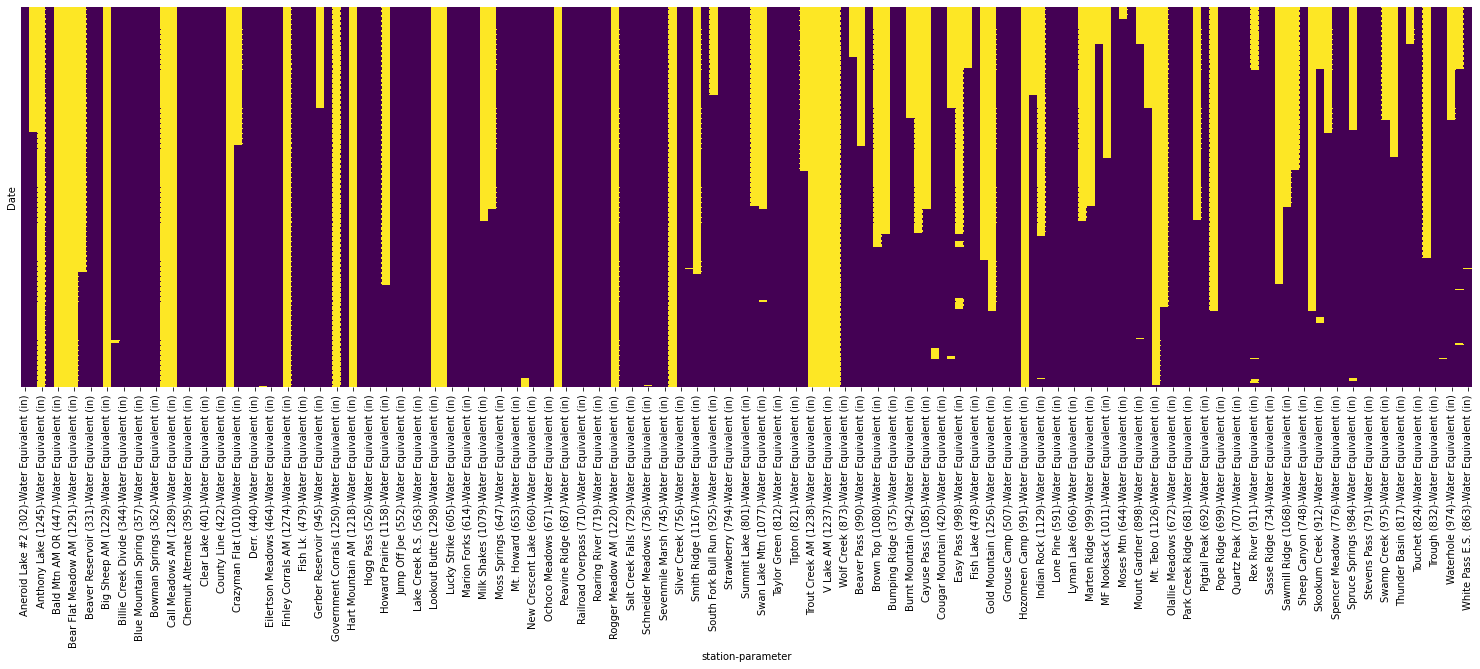

In [233]:
#Heatmap of missing Water Equivalent data.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,7))
sns.heatmap(ORWA_SWE.isnull(),yticklabels=False,cbar=False,cmap='viridis')

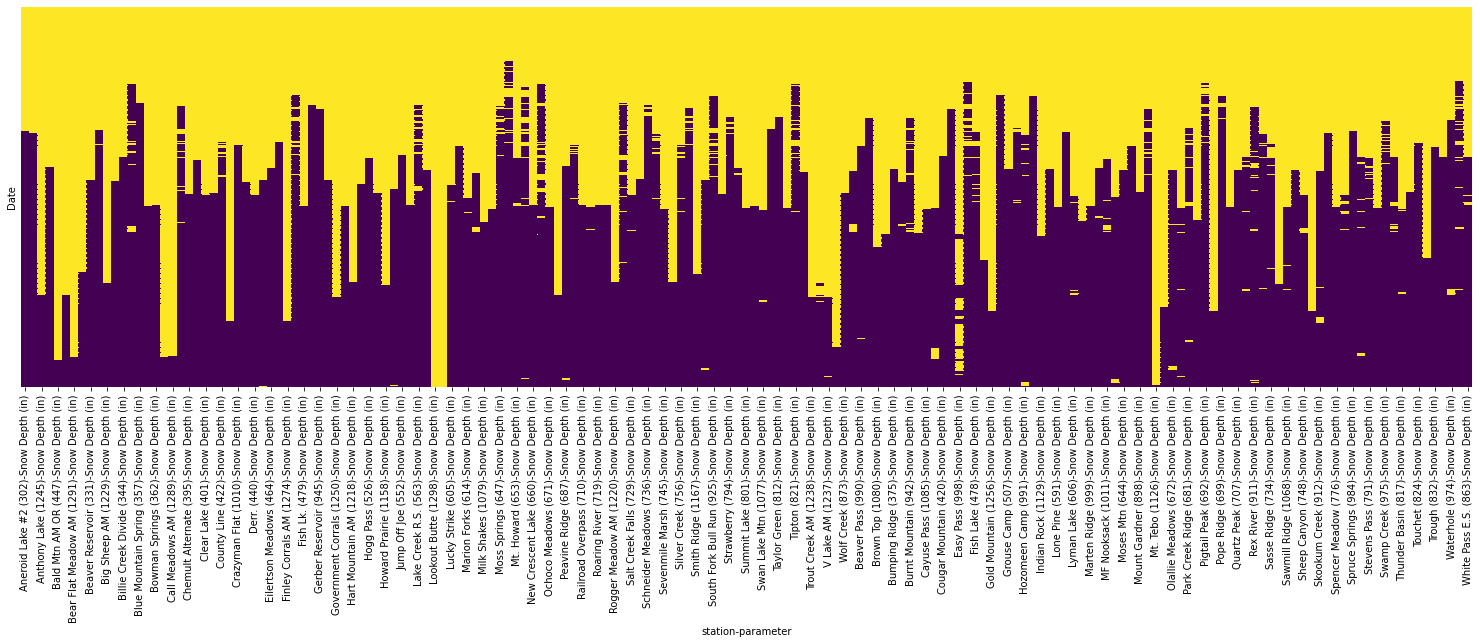

In [235]:
#Heatmap of missing Snow Depth data.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,7))
sns.heatmap(ORWA_SNWD.isnull(),yticklabels=False,cbar=False,cmap='viridis')

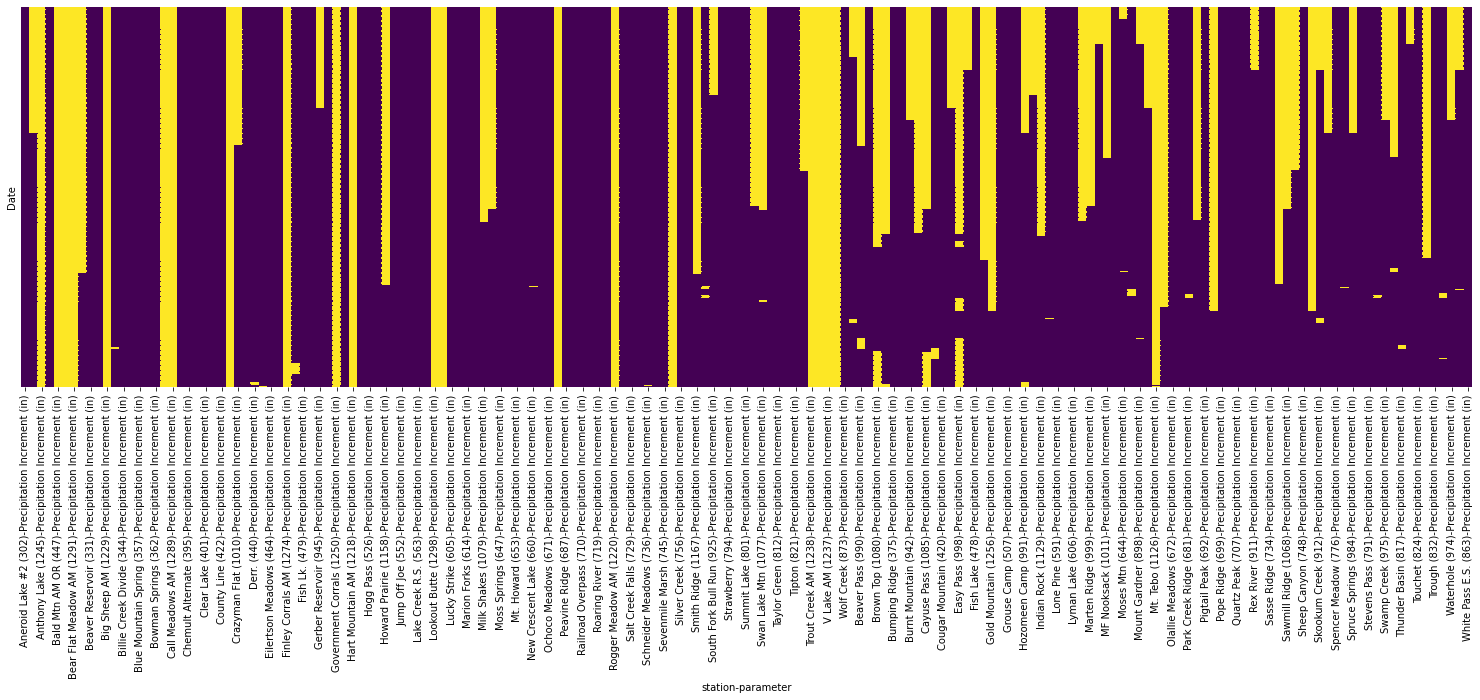

In [234]:
#Heatmap of missing Incremental Precip data.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,7))
sns.heatmap(ORWA_Precip_Incr.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Outlier detection using box plots

In [ ]:
# params = ['AirTemp (degF)', 'SWE (in)', 'Precip (in)']
# # for i in range(0,3):
# bla = [ORWA_Sites2['Aneroid Lake #2 (302)'][params[i]] for i in range(0,3)]

In [ ]:
def boxplots(station, data_pt_type):

  params = ['AirTemp (degF)', 'SWE (in)', 'Precip (in)']

  df = [ORWA_Sites2[station][params[i]] for i in range(0,3)]

  fig = go.Figure()
  for i in range(0,3):
  #   WA = WA_Sites[WA_Sites[i] != 0].dropna()

    fig.add_trace(go.Box(y = df[i], 
            name = params[i],
            boxpoints=data_pt_type, #options include: 'all', 'outliers','suspectedoutliers'
            hovertext = df[i].index,
            jitter=0.2,
            whiskerwidth=0.5                
    ))

  fig.update_layout(
          autosize=False,
          width=1200,
          height=500,
          margin=dict(l=20, r=20, t=2, b=8),
          paper_bgcolor="LightSteelBlue",
          title={
          'text': f'{station}',
          'y':0.98,
          'x':0.45,
          'xanchor': 'center',
          'yanchor': 'top'
          }
  )

  fig.show()

In [ ]:
boxplots('Aneroid Lake #2 (302)', data_pt_type='suspectedoutliers')

### Outlier detection and data gap tool using regression

In [ ]:
#In the works...

In [ ]:
# df = ORWA_Sites2[['Corral Pass (418)','Pigtail Peak (692)']]
# df2 = pd.merge(df['Corral Pass (418)']['SWE (in)'], df['Pigtail Peak (692)']['SWE (in)'], left_on='Date', right_on="Date").dropna()
# df2
# Pigtail Peak (692)

In [ ]:
# type(df2['SWE (in)_x'])
# type(np.array(df2['SWE (in)_x']).reshape(-1, 1))
# np.array(df2['SWE (in)_x']).reshape(-1, 1)
# X = np.array(df2['SWE (in)_x']).reshape((-1, 1))


pandas.core.series.Series

In [ ]:
df = pd.merge(ORWA_Sites2['Corral Pass (418)']['SWE (in)'], ORWA_Sites2['Pigtail Peak (692)']['SWE (in)'], left_on='Date', right_on="Date").dropna()

X = np.array(df['SWE (in)_x']).reshape(-1, 1)  
y = np.array(df['SWE (in)_y']) #.squeeze()

#LassoCV has built-in cross-validation to figure out the best alpha/regulizer value.  
#Just have to provide the alphas for it to run.  Default is (0.1,1,10).  Crazy simple.
model = LassoCV(alphas=(0.001,0.01,0.1,1,10,100,1000)).fit(X,y)
# model = LinearRegression().fit(X, y) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

In [ ]:
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', r_sq)
print('slope:', model.coef_)
print('intercept:', model.intercept_)

coefficient of determination: 0.9654944604834336
slope: [1.55448013]
intercept: -0.4571027759898634


In [ ]:
y_pred = model.predict(X_test)

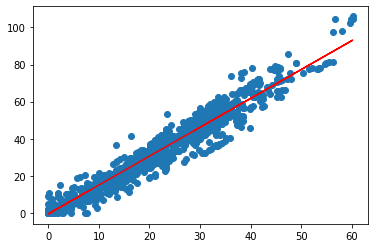

In [ ]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, '-r')

# pd.DataFrame(y_pred).plot()
# pd.DataFrame(y_test).plot()

In [ ]:
y_pred

array([-0.45710278, 24.57002737, 53.32790984, ..., -0.45710278,
       33.11966811, 46.9545413 ])

In [ ]:
y_test

array([ 0. , 15.3, 38.2, ...,  0. , 35.8, 46.5])

### Double Mass Functions

#### Selecting top correlated station to run double mass

In [231]:
def double_mass5(site_of_interest, parameter, month, num_of_stat, time_freq):  #If you set month to a default, python sees it as a key-value argument which will break *args.
  # global df2,years, yr, x, y, cumsum, top_corr_stations, top_corr_stations2, corr,stations, tcs #used for troubleshooting

#Get top correlated sites based on selected parameter
  top_corr_stations = ORWA_Sites2.corr()[site_of_interest].reset_index()[['parameter','station','Precipitation Increment (in)']]
  tcs = top_corr_stations[top_corr_stations['parameter']=='Precipitation Increment (in)'].sort_values('Precipitation Increment (in)',ascending=False).iloc[:num_of_stat,:]
  print(tcs[['station', f'{parameter}']].set_index('station'))

  stations = tcs['station'].tolist()  #make sure to use this method to convert column to a list instead of just subsetting or else it will include the indices with the stations.

 #Compile and filter data with respect to double_mass function inputs:
  site_list = [ORWA_Sites2[stations[i]][parameter].dropna() for i in range(len(stations))]  #.resample(time_freq).sum()
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged.resample(time_freq).sum()  #if this is temperature, precip_accum, or maybe others, this may need to be mean instead.
  df2.columns = [f'{stations[i]} {parameter}' for i in range(len(stations))]
 

#Add column specifying the water year (Oct 1 - Sep 30) of each record:
#Even though the index is already set as datetime, regular datetime objects have different methods than datetimeindices.  So...
#we have to reset the index so the dates become just a regular datetime object which then we can use the .dt.year methods with.
#Having an argument as a datetime is apparently different than a datetimeindex...super confusing. Can also import datetime too which does additional mysterious things.
  df2.reset_index(inplace=True)
  pd.to_datetime(df2['Date'])
  df2['water_year'] = df2['Date'].dt.year.where(df2['Date'].dt.month < 10, df2['Date'].dt.year + 1)
  df2.insert(1, 'water_year', df2.pop('water_year'))

#Create separate dataframes for each water year
  df2.set_index('water_year', inplace=True)
  years = list(range(int(df2.index[0]), int(df2.index[-1])))
  yr = [df2.loc[str(years[i])] for i in range(0,len(years))]
  yr = [yr[i].reset_index() for i in range(0,len(years))]

# Double Mass Analysis

  cumsum = [yr[i].set_index('Date').cumsum() for i in range(0,len(years))]  
  x = [cumsum[i].iloc[:,1] for i in range(len(years))]  
  y = [np.mean(cumsum[i].iloc[:,2:], axis=1) for i in range(0,len(years))]


  # customdata_list = [df2.iloc[:,0], x, y]
  # customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
  # customdata.reset_index(inplace=True)
  # print(customdata.iloc[:,0])

  fig = go.Figure()
 
  for i in range(0,len(years)):
    y[i].columns = ['reduced_cumsum']

  for i in range(0,len(years)):
    fig.add_trace(go.Scatter(
      x=x[i],
      y=y[i],
      mode='lines',
      name=f'{x[i].index[0].strftime("%Y")}',
      hovertext = x[i].index,   
  ))


  fig.update_xaxes(title_text= f"Cumulative {parameter} at {stations[0]}")
  fig.update_yaxes(title_text=f"Cumulative Mean {parameter} of Comparison Sites <br>{stations[1::]}</br>")

  fig.update_layout(
   height=800,
   width=1100,
  
  )

  fig.show()
 

### Double Mass Analysis for various sites

#### Fire: site burned entirely

In [225]:
double_mass5('Aneroid Lake #2 (302)', parameter='Precipitation Increment (in)',num_of_stat = 5, month=0, time_freq = 'D')  #Sasse Ridge (734)  	Aneroid Lake #2 (302)   Corral Pass (418) Blewett Pass (352)

parameter                  station  Precipitation Increment (in)
177          Aneroid Lake #2 (302)                      1.000000
237               Mt. Howard (653)                      0.792157
253        Schneider Meadows (736)                      0.619275
339           Spruce Springs (984)                      0.613833
207        Eilertson Meadows (464)                      0.595521


In [228]:
double_mass5('Corral Pass (418)', parameter='Precipitation Increment (in)',num_of_stat = 2, month=0, time_freq = 'D')  #Sasse Ridge (734)  	Aneroid Lake #2 (302)   Corral Pass (418) Blewett Pass (352)

parameter             station  Precipitation Increment (in)
288         Corral Pass (418)                      1.000000
334        Skate Creek (1257)                      0.850497


In [229]:
double_mass5('Diamond Lake (442)', parameter = 'Precipitation Increment (in)', num_of_stat=4, month=0, time_freq = 'D')  #'Annie Springs (1000)'

parameter                  station  Precipitation Increment (in)
206             Diamond Lake (442)                      1.000000
272        Toketee Airstrip (1044)                      0.893820
178           Annie Springs (1000)                      0.839741
239        New Crescent Lake (660)                      0.832829


In [230]:
double_mass5('Annie Springs (1000)', parameter = 'Precipitation Increment (in)', num_of_stat=4, month=0, time_freq = 'D')  #'Annie Springs (1000)'

parameter                station  Precipitation Increment (in)
178         Annie Springs (1000)                      1.000000
266              Sun Pass (1078)                      0.841332
206           Diamond Lake (442)                      0.839741
255        Sevenmile Marsh (745)                      0.837633


In [ ]:
double_mass4('Corral Pass (418)', 'Huckleberry Creek (928)', 'Morse Lake (642)',parameter='Precip (in)',month=0, time_freq = 'D')
#Corral Pass burned down in 2018

In [ ]:
double_mass4('Diamond Lake (442)', 'Summit Lake (801)', parameter='Precip (in)', month=0, time_freq = 'D')  #'Annie Springs (1000)'
#Burnt down sometime in late summer fires of 2020.

#### Fire nearby, but site remained intact

In [ ]:
double_mass4('Moses Mtn (644)', 'Sentinel Butte (1043)', parameter = 'Precip (in)', month=0, time_freq = 'D')
#Installed snow pillow on 9/4/2003 at Sentinel Butte.
#Moses installed 2003/4

In [ ]:
double_mass4('Sasse Ridge (734)', 'Fish Lake (478)','Olallie Meadows (672)','Stampede Pass (788)', parameter= "SWE (in)", month=0, time_freq = 'D')

In [ ]:
double_mass4('Sentinel Butte (1043)', 'Moses Mtn (644)',month=0, parameter="SWE (in)", time_freq = 'D') #, 'Bunchgrass Mdw (376)'

In [ ]:
double_mass4('Mckenzie (619)', 'Bear Grass (1166)', 'Hogg Pass (526)', parameter='SWE (in)', month=0, time_freq = 'D') #, 'Bunchgrass Mdw (376)'
#nothing obvious is sitevisit log that would indicate a reason for the data to change in 2012 at McKenzie, Bear Grass, or Hogg Pass
#Bear was installed Sep 2011

#### Pillow Alterations

In [ ]:
double_mass4('Roaring River (719)', 'Irish Taylor (545)', 'Cascade Summit (388)', month=0, parameter='SWE (in)', time_freq='D')

In [ ]:
double_mass4('Railroad Overpass (710)', 'Salt Creek Falls (729)', month=0, parameter='SWE (in)', time_freq='D')  #'Holland Meadows (529)', 'Cascade Summit (388)'

In [ ]:
double_mass4('Mud Ridge (655)', 'Clear Lake (401)','Red Hill (712)', time_freq='D', parameter='AirTemp (degF)', month=0) #'Clackamas Lake (398)', 'Mt Hood Test Site (651)'